<h1>1. Business Problem </h1>

<h2> 

It can be hard to know how much something’s really worth. Small details can mean big differences in pricing. For example, one of these sweaters cost  335 dollar and the other cost 9.99 dollar. Can you guess which one’s which....

Product pricing gets even harder at scale, considering just how many products are sold online. Clothing has strong seasonal pricing trends and is heavily influenced by brand names, while electronics have fluctuating prices based on product specs.

Mercari, Japan’s biggest community-powered shopping app, knows this problem deeply. They’d like to offer pricing suggestions to sellers, but this is tough because their sellers are enabled to put just about anything, or any bundle of things, on Mercari's marketplace.

In this competition, Mercari’s challenging you to build an algorithm that automatically suggests the right product prices. You’ll be provided user-inputted text descriptions of their products, including details like product category name, brand name, and item condition. </h2>

<h2> 1.1 Real World / Business Objectives and Constraints </h2>


**A. Define the objective in business terms:** The objective is to come up with the right pricing algorithm that can we can use as a pricing recommendation to the users. 

**B. How will your solution be used?:** Allowing the users to see a suggest price before purchasing or selling will hopefully allow more transaction within Mercari's business. 

**C. How should you frame this problem?:** This problem can be solved using a supervised learning approach, and possible some unsupervised learning methods as well for clustering analysis. 

**D. How should performance be measured?:** Since its a regression problem, the evaluation metric that should be used is RMSE (Root Mean Squared Error). But in this case for the competition, we'll be using the RMSLE; which puts less penalty on large errors and focuses more on the smaller errors (since our main distribution in price is centered at around $10)

** E. Are there any other data sets that you could use?:** To get a more accurate understanding and prediction for this problem, a potential dataset that we can gather would be more about the user. Features such as user location, user gender, and seasonality. 



<h1>2. Machine Learning problem </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<h3> 
Data fields

The files consist of a list of product listings. These files are tab-delimited.

* train_id or test_id - the id of the listing

* name - the title of the listing. Note that we have cleaned the data to remove text that look like prices (e.g. 20 dollar) to avoid leakage. These removed prices are represented as rm

* item_condition_id - the condition of the items provided by the seller

* category_name - category of the listing

* brand_name

* price - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv since that is what you will predict.

* shipping - 1 if shipping fee is paid by seller and 0 by buyer

* item_description - the full description of the item. Note that we have cleaned the data to remove text that look like prices (e.g. 20 dollar) to avoid leakage. These removed prices are represented as rm
 </h3>

Refer: https://www.kaggle.com/c/mercari-price-suggestion-challenge/data

<h2>2.2 Mapping the real-world problem to a Machine Learning Problem </h2>

<h3> 2.2.1 Type of Machine Learning Problem </h3>

<p> It is a regression problem  <br>

<h3>2.2.2 Performance metric </h3>

<p> log of Root mean squared error (RMSLE) <br>




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import random

sns.set_context('notebook',font_scale=1.5)


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Mercari/train.tsv', sep='\t', nrows=10000)

In [4]:
data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [5]:
data.shape

(10000, 8)

#### Explore dataset

In [6]:
data.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [7]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
train_id,10000.0,4999.5000,2886.895680,0.0,2499.75,4999.5,7499.25,9999.0
item_condition_id,10000.0,1.9050,0.908107,1.0,1.00,2.0,3.00,5.0
price,10000.0,26.4299,39.385515,0.0,10.00,16.0,29.00,1506.0
shipping,10000.0,0.4539,0.497895,0.0,0.00,0.0,1.00,1.0


In [8]:
data.astype('object').describe().transpose()

,count,unique,top,freq
train_id,10000,10000,9999,1
name,10000,9846,Bundle,13
item_condition_id,10000,5,1,4364
category_name,9953,626,"Women/Athletic Apparel/Pants, Tights, Leggings",396
brand_name,5739,761,Nike,350
price,10000,213,10,691
shipping,10000,2,0,5461
item_description,10000,9261,No description yet,578


In [9]:
data.nunique()

train_id             10000
name                  9846
item_condition_id        5
category_name          626
brand_name             761
price                  213
shipping                 2
item_description      9261
dtype: int64

In [10]:
data['item_condition_id'] = data['item_condition_id'].astype('category')
data['shipping'] = data['shipping'].astype('category')


In [11]:
data.dtypes

train_id                int64
name                   object
item_condition_id    category
category_name          object
brand_name             object
price                 float64
shipping             category
item_description       object
dtype: object

In [12]:
data.isnull().sum()

train_id                0
name                    0
item_condition_id       0
category_name          47
brand_name           4261
price                   0
shipping                0
item_description        0
dtype: int64

In [13]:
# Create a function to impute missing values
def fill_missing_value(data):
    data['category_name'].fillna(value = 'Other', inplace=True)
    data['brand_name'].fillna(value = 'uknown', inplace=True)
    data['item_description'].fillna(value = 'No description yet', inplace=True)
    
    return data
  
fill_missing_value(data)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,uknown,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,uknown,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,uknown,44.0,0,Complete with certificate of authenticity
...,...,...,...,...,...,...,...,...
9995,9995,Halloween nail stickers,1,Beauty/Makeup/Nails,uknown,3.0,1,New. Both sets included *please only purchase ...
9996,9996,NWT Wildfox Fringe Top XS Coachella,1,Women/Tops & Blouses/T-Shirts,Wildfox Couture,17.0,0,NWT Wildfox Coachella Fringe Top size XS. Mint...
9997,9997,Like New Baby Carrier,2,Kids/Gear/Backpacks & Carriers,Chicco,15.0,1,Excellent condition. No tears no stains used m...
9998,9998,Minecraft Creeper Scarf,1,Kids/Boys (4+)/Accessories,uknown,12.0,1,"A scarf is a trusty companion, covering your n..."


In [14]:
data.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

#### Observation:

* Data has some rows and columns
* Data has 8 columns including 3 categorical, 1 text, 2 numerical categorical and 2 numerical columns
* Each category has different unique values that we will further investigate in EDA part
* Basic statistics shows that price feature has outliers and has not gaussian distribution that we will see in EDA
* We have 47 missing values for category name and 4254 missing value for brand name that we have to deal with it in EDA part

#### Exploratory Data Analysis

#### Price

Text(0.5, 1.0, 'Price Distribution')

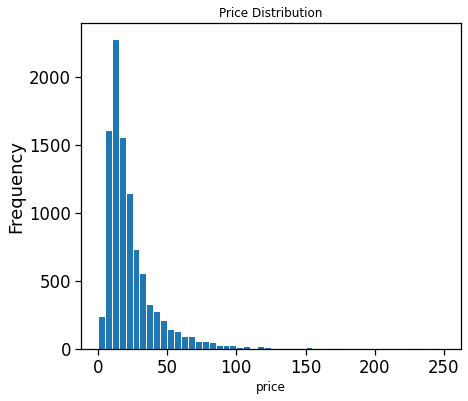

In [15]:
# Plot Price Distribution
plt.subplot(1, 2, 1)
(data['price']).plot.hist(bins=50, figsize=(15, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

#Plot Log Price Distribution
#plt.subplot(1, 2, 2)
#np.log(train['price']+1).plot.hist(bins=50, figsize=(15,6), edgecolor='white')
#plt.xlabel('log(price+1)', fontsize=12)
#plt.title('Log Price Distribution', fontsize=12)

#plt.show()

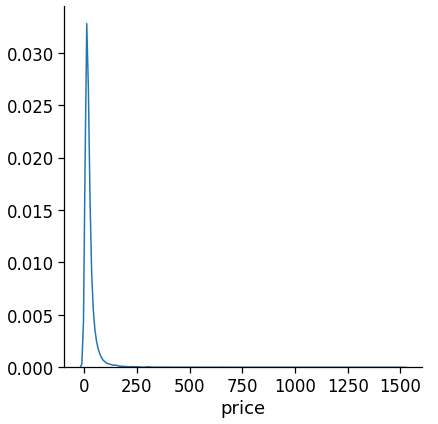

In [16]:

#pdf of units
sns.FacetGrid(data,size=6) \
      .map(sns.kdeplot,"price") \
      .add_legend();
plt.show();

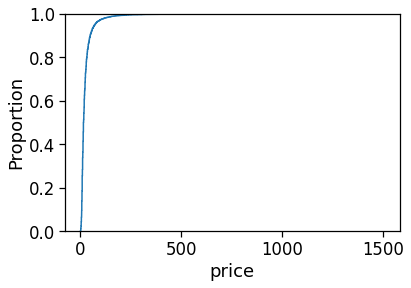

In [17]:
sns.ecdfplot(data=data, x='price')

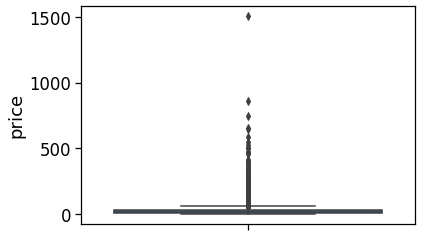

In [18]:
sns.boxplot(y='price', data=data)
plt.show()

In [19]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = data["price"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 8.0
20 percentile value is 10.0
30 percentile value is 12.0
40 percentile value is 14.0
50 percentile value is 16.0
60 percentile value is 20.0
70 percentile value is 25.0
80 percentile value is 33.0
90 percentile value is 50.0
100 percentile value is  1506.0


In [20]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = data["price"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 50.0
91 percentile value is 54.0
92 percentile value is 56.0
93 percentile value is 60.0
94 percentile value is 66.0
95 percentile value is 73.0
96 percentile value is 81.0
97 percentile value is 95.0
98 percentile value is 120.0
99 percentile value is 171.0
100 percentile value is  1506.0


In [21]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = data["price"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 171.0
99.1 percentile value is 180.0
99.2 percentile value is 190.0
99.3 percentile value is 206.0
99.4 percentile value is 225.0
99.5 percentile value is 245.0
99.6 percentile value is 259.0
99.7 percentile value is 305.0
99.8 percentile value is 380.0
99.9 percentile value is 500.0
100 percentile value is  1506.0


In [22]:
#removing further outliers based on the 99.9th percentile value
data=data[(data.price>0) & (data.price<460)]

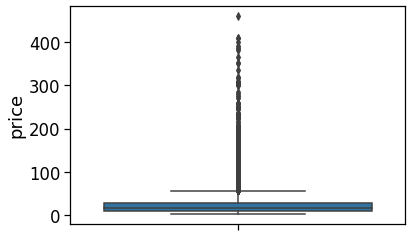

In [23]:
# box-plot for units after removing outliers
sns.boxplot(y="price", data=data)
plt.show()

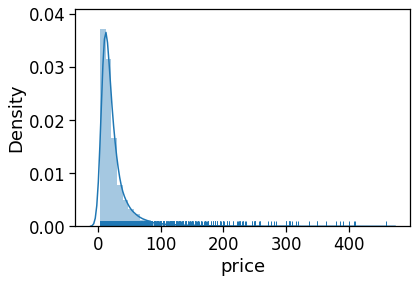

In [24]:
sns.distplot(data['price'], rug=True, kde=True, bins=50)

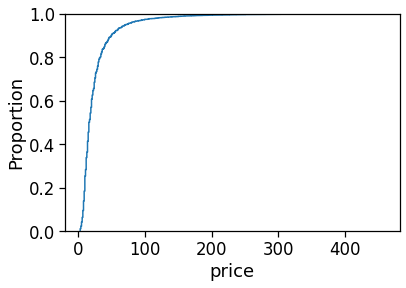

In [25]:
sns.ecdfplot(data=data, x='price')

In [26]:
data['price'].value_counts()

10.0     691
12.0     551
14.0     491
9.0      453
16.0     452
        ... 
145.0      1
276.0      1
459.0      1
221.0      1
158.0      1
Name: price, Length: 200, dtype: int64

#### Observation:

* Price feature has right skw distribution
* First we remove the outliers
* 99% probability says that all the product price lies between 0 to 100 while 1% product has price range lies between 100 to 400
* We will do log transformation before model building to make it gaussian distribution

#### Item condition id & shipping

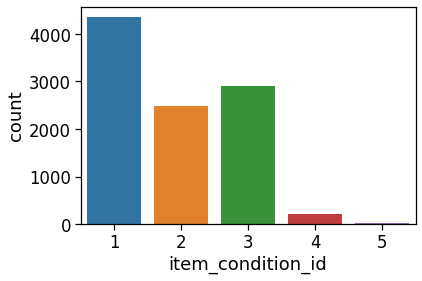

In [27]:
sns.countplot(x='item_condition_id', data=data)

In [28]:
data['item_condition_id'].value_counts(normalize=True)*100

1    43.666065
3    29.134095
2    24.804570
4     2.194829
5     0.200441
Name: item_condition_id, dtype: float64

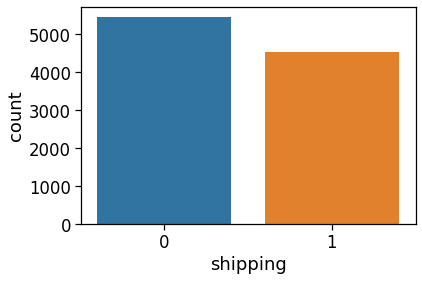

In [29]:
sns.countplot(x='shipping', data=data)

In [30]:
data['shipping'].value_counts(normalize=True)*100

0    54.630186
1    45.369814
Name: shipping, dtype: float64

#### Observation:

* item condition id has five unique category. id 1, id 2 and id 3 has major counts 43070, 29017 and 25428 resectively while id 4 has 2161 and id 5 has only 167 counts
* shipping has almost equal distribution. 55155 products include no shipping and 44688 products include shipping

#### category name and brand name 

In [31]:
data['category_name'].value_counts()

Women/Athletic Apparel/Pants, Tights, Leggings    395
Women/Tops & Blouses/T-Shirts                     294
Beauty/Makeup/Face                                271
Beauty/Makeup/Lips                                227
Beauty/Makeup/Eyes                                185
                                                 ... 
Kids/Boys (4+)/Accessories                          1
Home/Kitchen & Dining/Other                         1
Handmade/Crochet/Supplies                           1
Handmade/Housewares/Other                           1
Sports & Outdoors/Golf/Golf Apparel                 1
Name: category_name, Length: 627, dtype: int64

In [32]:
data['brand_name'].value_counts()

uknown               4254
Nike                  349
PINK                  348
Victoria's Secret     322
LuLaRoe               201
                     ... 
Fox                     1
Belkin                  1
London Times            1
Marciano                1
Willow Tree             1
Name: brand_name, Length: 760, dtype: int64

#### Observation:

* We have 971 different product category but we will explore more to see which product category has more products so we can analyse it better
* We have 2064 different product brand category and we will see more about it into EDA part

#### item description

In [33]:
import spacy
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 15000000 #or any large value, as long as you don't run out of RAM

In [34]:
# combined all item description and join with space
combined_description = ' '.join(data.item_description.values)

# store all combined tweets into doc file
doc = nlp(combined_description)

In [35]:
def gen_freq(tokens):

  word_freq = pd.Series([token.text for token in tokens]).value_counts()
  print(word_freq[:20])
  return word_freq

In [36]:
word_freq = gen_freq(doc)

.       14580
,        9359
!        5577
and      5264
the      3631
a        3564
for      3420
in       3052
to       2926
with     2879
is       2756
-        2754
*        2320
of       2262
I        2152
new      2017
:        2002
on       1769
]        1616
)        1592
dtype: int64


In [37]:
!pip install wordcloud

In [38]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [39]:
print('No of unique words:', len(word_freq))

No of unique words: 23860


In [40]:
# create fuc to visualisa word frequqncy
def generate_wordcloud(data):

  wc = WordCloud(width=400, height=330, max_words=200, background_color='black').generate_from_frequencies(data)
  plt.figure(figsize=(14,12))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.title("Top 200 most frequent unique words")
  plt.show()

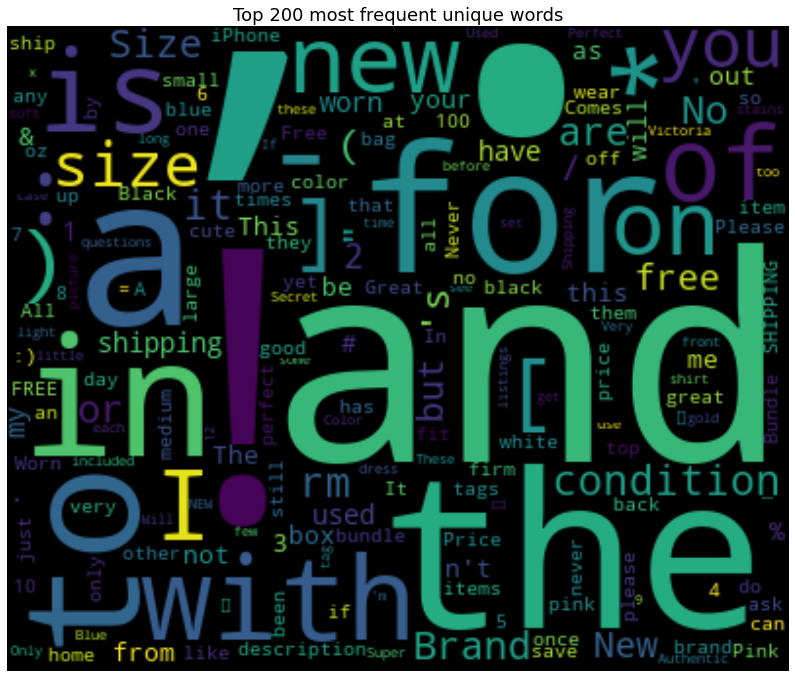

In [41]:
generate_wordcloud(word_freq)

#### Observation:

* We can see that we have lot of noice in our description feature that we have to clean it before analysing 

#### Bivariate analysis

#### shipping vs price

Text(0.5, 1.0, 'Frequency of price by shipping')

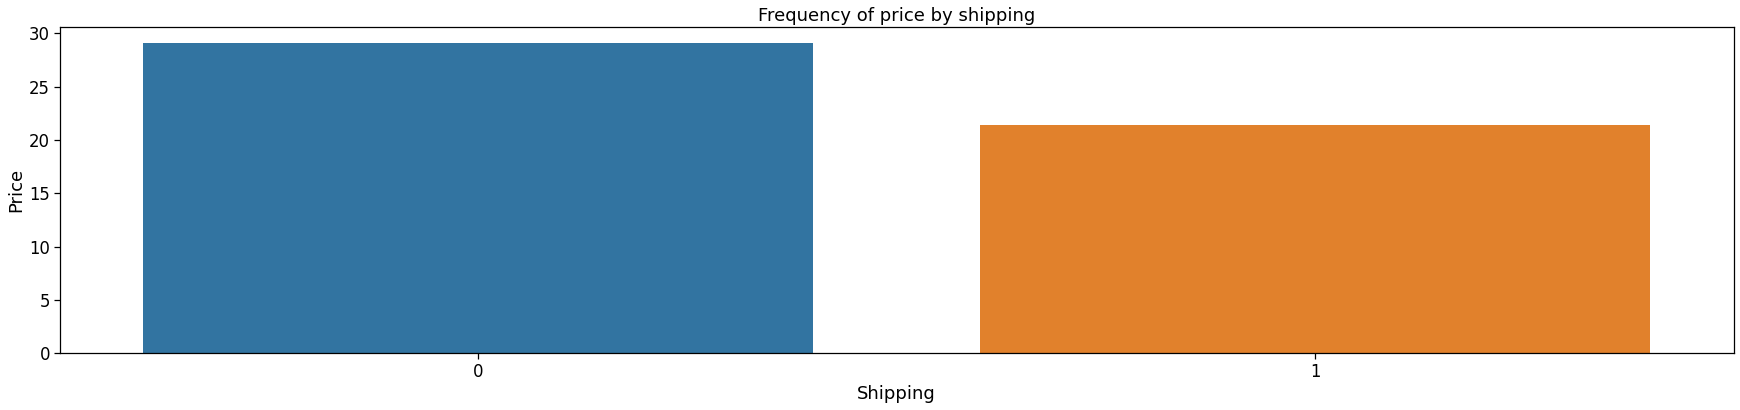

In [42]:
plt.figure(figsize=(30, 6))
group_2=data.groupby('shipping').price.mean()
sns.barplot(group_2.index, group_2.values)
plt.ylabel('Price')
plt.xlabel('Shipping')
plt.title('Frequency of price by shipping')

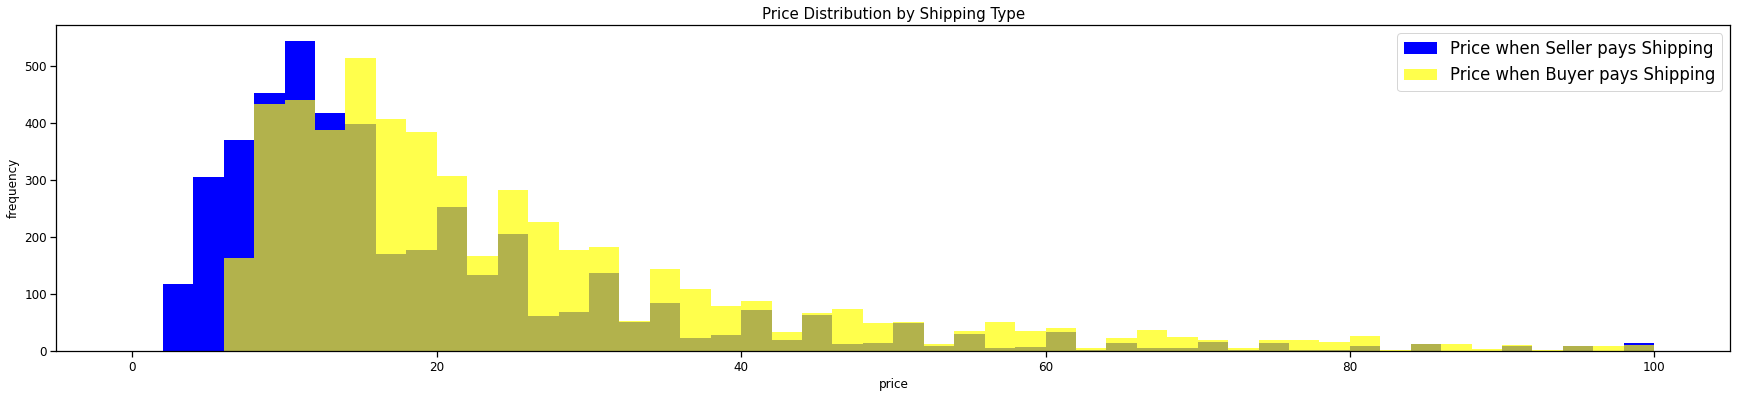

In [43]:
shipping_fee_by_buyer = data.loc[data['shipping'] == 0, 'price']
shipping_fee_by_seller = data.loc[data['shipping'] == 1, 'price']

fig, ax = plt.subplots(figsize=(30,6))

ax.hist(shipping_fee_by_seller, color='blue', alpha=1.0, bins=50, range = [0, 100],label='Price when Seller pays Shipping')
ax.hist(shipping_fee_by_buyer, color='yellow', alpha=0.7, bins=50, range = [0, 100],label='Price when Buyer pays Shipping')

plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

In [44]:
print('The average price is {}'.format(round(shipping_fee_by_seller.mean(), 2)), 'if seller pays shipping');
print('The average price is {}'.format(round(shipping_fee_by_buyer.mean(), 2)), 'if buyer pays shipping')

The average price is 21.42 if seller pays shipping
The average price is 29.13 if buyer pays shipping


#### Observation:

* Distribution clearly says that product price is higher if shipping free and it is very obvious. If product price is low then we have to pay shipping cost on top of it. 

* The average price is 21.42 if seller pays shipping
The average price is 29.13 if buyer pays shipping

#### category vs price

In [45]:
top_10_category = data['category_name'].value_counts()[:10].reset_index()
top_10_category

,index,category_name
0,"Women/Athletic Apparel/Pants, Tights, Leggings",395
1,Women/Tops & Blouses/T-Shirts,294
2,Beauty/Makeup/Face,271
3,Beauty/Makeup/Lips,227
4,Beauty/Makeup/Eyes,185
5,"Electronics/Cell Phones & Accessories/Cases, C...",170
6,Electronics/Video Games & Consoles/Games,163
7,Women/Tops & Blouses/Blouse,146
8,Women/Underwear/Bras,142
9,"Women/Tops & Blouses/Tank, Cami",141


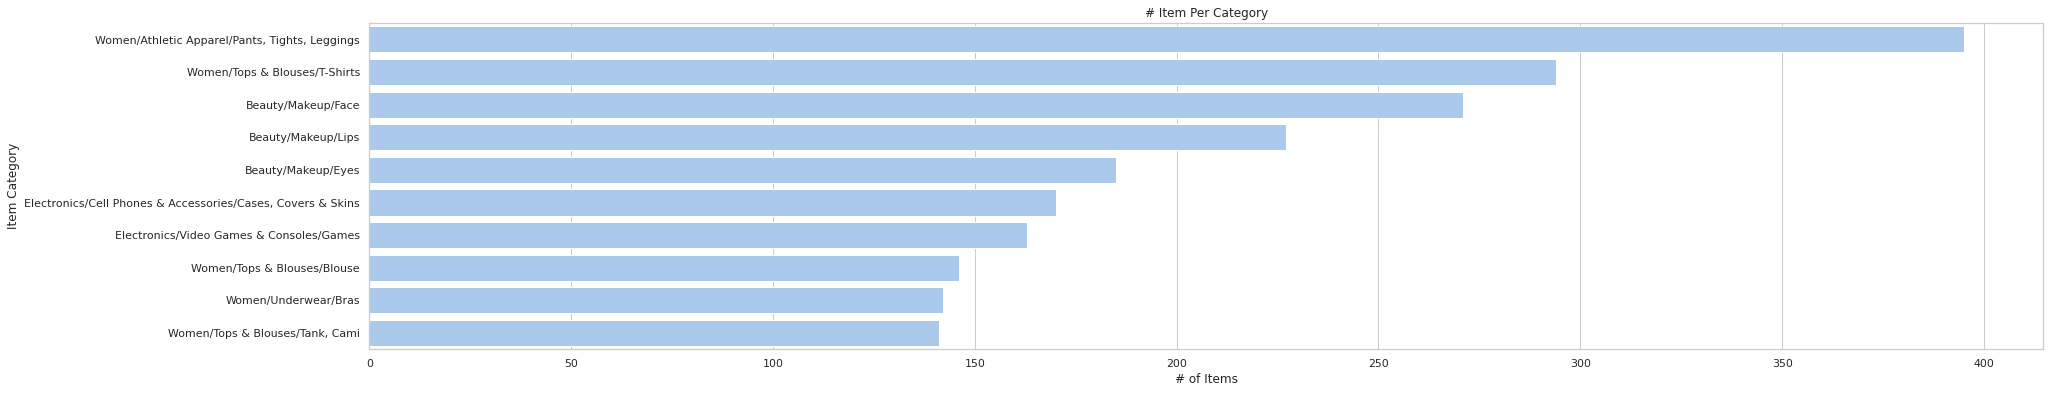

In [46]:
top_10_category = data['category_name'].value_counts()[:10].reset_index()

sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(30, 6))

# Plot the total items per category
sns.set_color_codes("pastel")
sns.barplot(x="category_name", y='index', data=top_10_category,
            label="# Items", color="b")

# Add a legend and informative axis label
ax.set( ylabel="Item Category", title='# Item Per Category',
       xlabel="# of Items")

plt.show()

In [47]:
# Feature Engineering (1): Creating new Category Features
def transform_category_name(category_name):
    try:
        main, sub1, sub2= category_name.split('/')
        return main, sub1, sub2
    except:
        return 'Other','Other','Other'

In [48]:
data['category_main'], data['category_sub1'], data['category_sub2'] = zip(*data['category_name'].apply(transform_category_name))

cat_train = data[['category_main','category_sub1','category_sub2', 'price']]

cat_train.head()

,category_main,category_sub1,category_sub2,price
0,Men,Tops,T-shirts,10.0
1,Electronics,Computers & Tablets,Components & Parts,52.0
2,Women,Tops & Blouses,Blouse,10.0
3,Home,Home Décor,Home Décor Accents,35.0
4,Women,Jewelry,Necklaces,44.0


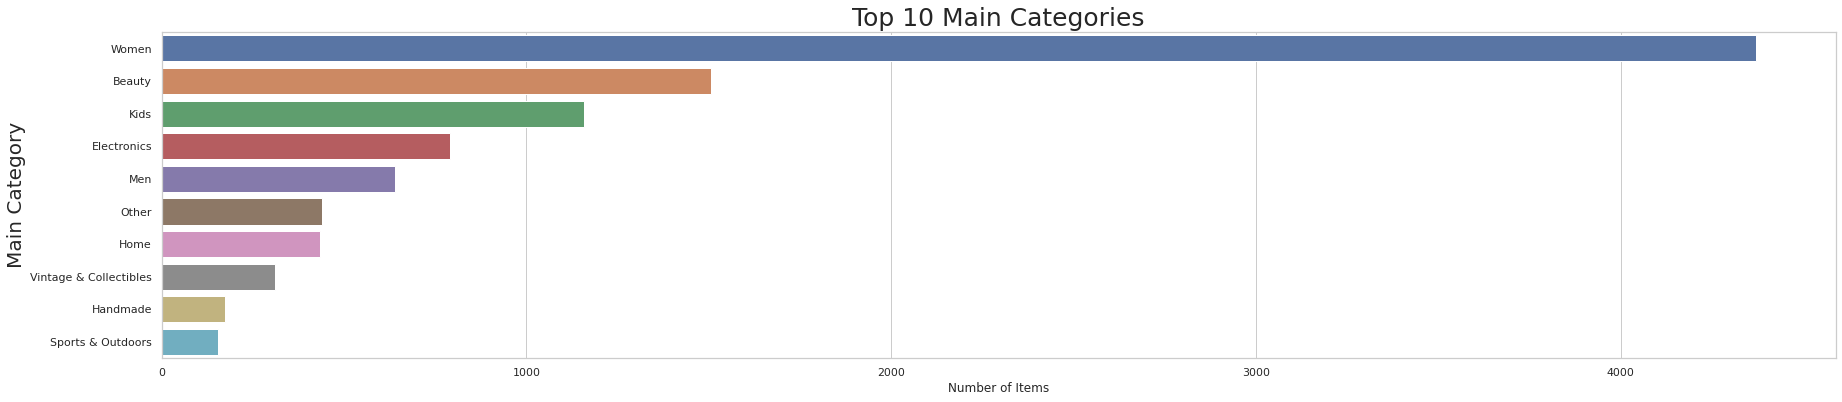

In [49]:
plt.figure(figsize=(30,6))
sns.countplot(y = data['category_main'], order = data['category_main'].value_counts().index, orient = 'v')
plt.title('Top 10 Main Categories', fontsize = 25)
plt.ylabel('Main Category', fontsize = 20)
plt.xlabel('Number of Items')
plt.show()

In [50]:
# Look at the ratio of category for items
data['category_main'].value_counts()/len(data)

Women                     0.438064
Beauty                    0.151032
Kids                      0.116055
Electronics               0.079174
Men                       0.064241
Other                     0.043997
Home                      0.043395
Vintage & Collectibles    0.031068
Handmade                  0.017438
Sports & Outdoors         0.015534
Name: category_main, dtype: float64

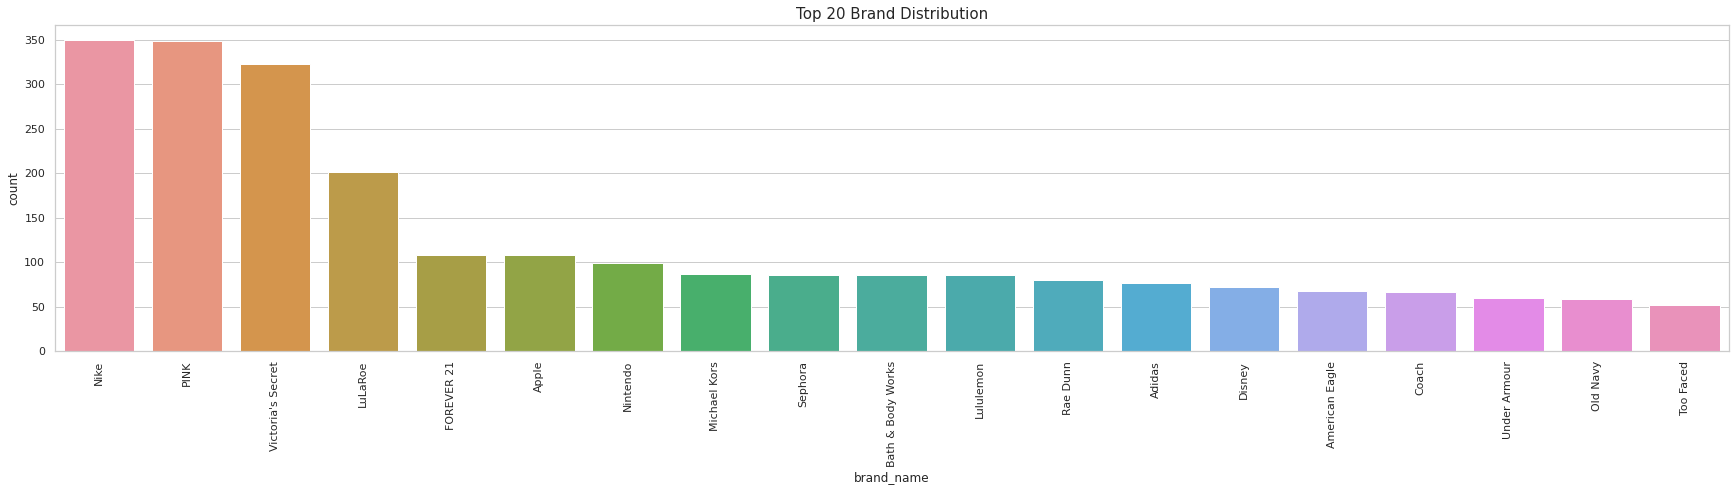

In [51]:
# Top 20 Brand Distribution
plt.figure(figsize=(30, 6))
b20 = data['brand_name'].value_counts()[1:20].reset_index().rename(columns={'index': 'brand_name', 'brand_name':'count'})
ax = sns.barplot(x="brand_name", y="count", data=b20)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top 20 Brand Distribution', fontsize=15)
plt.show()

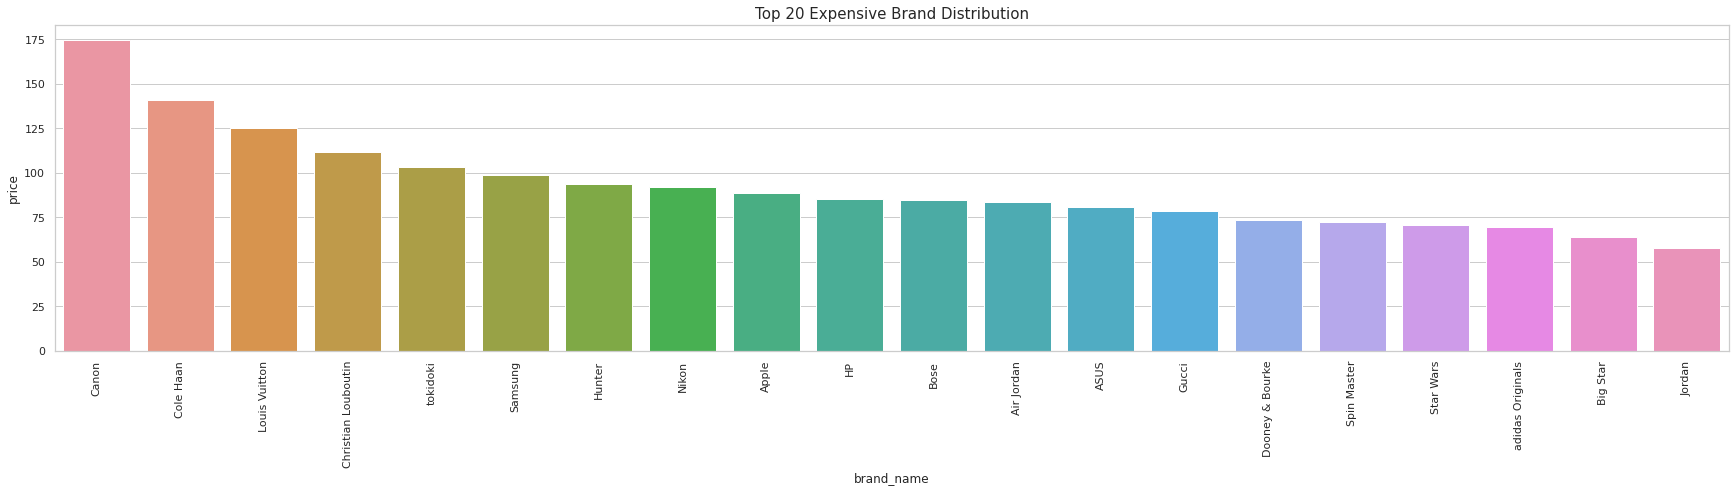

In [52]:
plt.figure(figsize=(30, 6))
top_20_exp_brand = pd.DataFrame(data.groupby(['brand_name'],as_index=True).std().price.sort_values(ascending=False)[0:20]).reset_index()
ax = sns.barplot(x="brand_name", y="price", data=top_20_exp_brand)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top 20 Expensive Brand Distribution', fontsize=15)
plt.show()

## Important points while doing analysis:

* miising value brand name are actually missing because some products does not have any brands then how to deal with it 
* some item desrciption does not has any description about products then how to deal with it many some people lazy to type it 
* low price is 0 so why is that? what is the reason?
* team efforts always ask question why this in group kaggle or in meeting in company
* remove 0 price values from the dataset because we do not want that our data learn from those infromation which has 0 price beacuse it does not make sense becasue it may possibel that data can corrupt because products have some price values no one see products with 0 price
* check distribvution of price with or without shipping 
* see the distribution of top 10 products category and see what are they from them you can further decision about marketing since these categoryes are selling more so focus on these categories only 
* if we have price feature missinbg values that we we need to do because it is target varibale and we cannpt manipulate it otherwise we can add bias into model or model can overfit so better to discuss with domain expert or manager however we can create features based on category meanncoding or max encoding 
* shipping feature is not telling right information since free shipping and cost shipping does not have that much difference
* in category if you find rootcategory/subcategory1/subcategory2 pattern we can create three different subcategory and we can able to do more eda into 
* we have brand feature init and to predict price brand name can make high impact on price
* for text we can simply ctreate word count feature then see scatter plot between word counts and price and see what is happening after that we can create binning feature based on word count with respect to price feature and it will give more information to model to learn non linear relationship like ensemble models
* fetaure engineering learn from inpute we you give more meaning full features you will get more accurate output bevcauyse we want to capture linbear and non linar realtionships that wsay we make it simple for model to learn 
* in this case study we do not have date features and this way we can create more human patterns like festivals events, 
* topic modeling is userful for any kind of text analysis such as survey data, classification, sentiment, 